In [465]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [466]:
# --------------------
# PARAMETERS
# --------------------
start_date = '1976-01-01'
end_date = '2020-01-01'
ticker = '^GSPC'
split = 0.2
window = 30

In [467]:
def qlike(realized_var, predicted_var):
    realized_var = np.asarray(realized_var)
    predicted_var = np.asarray(predicted_var)
    ratio = realized_var / predicted_var
    return np.mean(ratio - np.log(ratio) - 1)

### **Data Preparation**

In [468]:
# Import daily returns (in %)
data = yf.download(tickers=ticker, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

rets = 100 * np.log(data / data.shift(1))
rets = rets.dropna()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

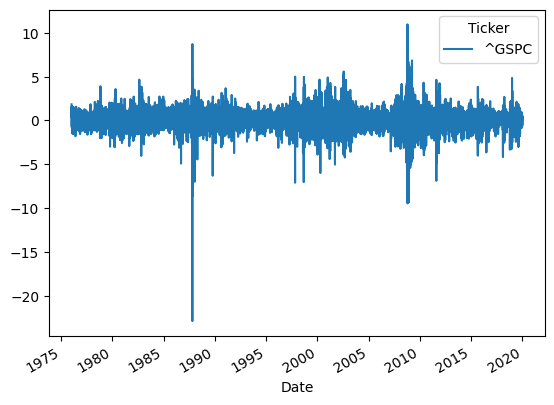

In [469]:
# VISUALISATION
rets.plot()

In [470]:
# Split training and test data
split_idx = int(rets.shape[0] * split)
train_data = rets[:split_idx]
test_data = rets[split_idx:]

### **Traditional GARCH Model**

The ARCH(q) model is defined by the mean equation
$$
r_t = \mu + \epsilon_t
$$
and the shock decomposition
$$
\epsilon_t = \sigma_t z_t, \qquad z_t \sim i.i.d.\ (0,1).
$$

The conditional variance of an ARCH(q) model is
$$
\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2,
$$
with the constraints
$$
\omega > 0, \qquad \alpha_i \ge 0, \qquad \sum_{i=1}^{q} \alpha_i < 1.
$$

For the ARCH(1) model, the conditional variance simplifies to
$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2,
$$
with constraints
$$
\omega > 0, \qquad \alpha_1 \ge 0, \qquad \alpha_1 < 1.
$$


In [471]:
# Defining and training ARCH(1) model on our training data
model_arch_1 = arch_model(train_data, vol='GARCH', p=1, q=1, mean='constant', dist='t')
res_arch_1 = model_arch_1.fit()
print(res_arch_1.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 262240.12434826815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2756.8495282461636
Iteration:      3,   Func. Count:     24,   Neg. LLF: 109076.41031514716
Iteration:      4,   Func. Count:     32,   Neg. LLF: 2755.1958631695907
Iteration:      5,   Func. Count:     39,   Neg. LLF: 2662.504096524728
Iteration:      6,   Func. Count:     46,   Neg. LLF: 2676.122492180506
Iteration:      7,   Func. Count:     53,   Neg. LLF: 2656.4886279022485
Iteration:      8,   Func. Count:     59,   Neg. LLF: 2656.459399963469
Iteration:      9,   Func. Count:     65,   Neg. LLF: 2656.458016839952
Iteration:     10,   Func. Count:     71,   Neg. LLF: 2656.4576184092857
Iteration:     11,   Func. Count:     77,   Neg. LLF: 2656.4575642226205
Iteration:     12,   Func. Count:     83,   Neg. LLF: 2656.4575633214963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2656.4575633214963
            Iterati

In [472]:
#print(res_arch_1.params)

In [473]:
# Compute the in-sample predictions of the training data
predictions_training = pd.Series(res_arch_1.conditional_volatility, index=train_data.index)

In [474]:
# Prediction of the testing sample
train_data = train_data.squeeze()
test_data = test_data.squeeze()
predictions_testing = []
history = train_data.copy()

for idx in range(test_data.shape[0]):
    # Fit the model on history (train data + previous test points)
    model = arch_model(history, vol='GARCH', p=1, q=1, mean='constant', dist='t')
    res = model.fit(disp='off')

    # Forecast 1-step ahead
    pred = res.forecast(horizon=1).variance.iloc[-1, 0]
    predictions_testing.append(np.sqrt(pred))

    # Add actual return to history
    new_point = pd.Series(
        data=[test_data.iloc[idx]],
        index=[test_data.index[idx]]
    )
    history = pd.concat([history, new_point])

predictions_testing = pd.Series(predictions_testing, index=test_data.index)

In [475]:
# Compute full predictions
full_predictions = pd.concat([predictions_training, predictions_testing])
full_predictions

Date
1976-01-05    0.939768
1976-01-06    0.986775
1976-01-07    0.985988
1976-01-08    0.969048
1976-01-09    0.957476
                ...   
2019-12-24    0.542851
2019-12-26    0.529976
2019-12-27    0.531343
2019-12-30    0.518859
2019-12-31    0.535033
Length: 11096, dtype: float64

In [476]:
# Compute rolling window of realized volatility
rets = rets.squeeze()
realized_var = (rets**2).rolling(window=window).mean()
realized_vol = realized_var ** 0.5

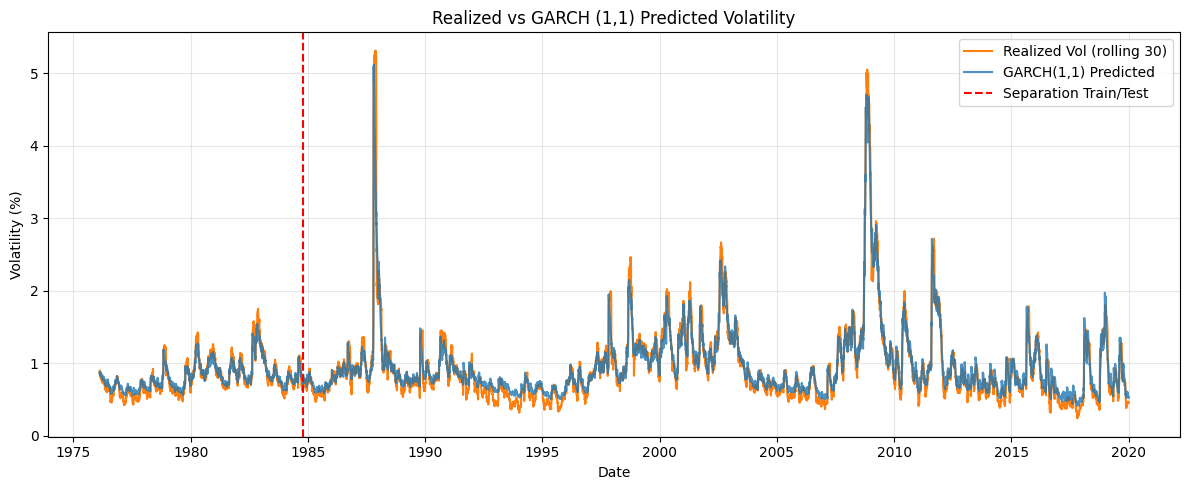

RMSE: 0.1353
MAE: 0.0878
QLIKE = 0.0324


In [477]:
# VISUALISATION

df = pd.concat(
    [realized_vol.rename("realized"), 
     full_predictions.rename("predicted")],
    axis=1,
    join="inner"
)

df = df.dropna()

realized  = df["realized"]
predicted = df["predicted"]

plt.figure(figsize=(12,5))
plt.plot(realized.index, realized, label=f'Realized Vol (rolling {window})', color='tab:orange')
plt.plot(predicted.index, predicted, label='GARCH(1,1) Predicted', alpha=0.8, color='tab:blue')

# optional uncertainty band around prediction (±20%)
#plt.fill_between(predicted.index, predicted * 0.8, predicted * 1.2, color='tab:blue', alpha=0.06)
plt.title('Realized vs GARCH (1,1) Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.axvline(x=train_data.index[-1], linestyle='--', c='r', label='Separation Train/Test')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print simple accuracy metrics on the overlapping sample
pred_var = predicted ** 2
real_var = realized ** 2
rmse = np.sqrt(mean_squared_error(realized, predicted))
mae = mean_absolute_error(realized, predicted)
qLike = qlike(real_var, pred_var)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'QLIKE = {qLike:.4f}')

### **EGARCH Model**

The EGARCH(1,1) model (Nelson, 1991) specifies the logarithm of the conditional variance as:

$$
\ln(\sigma_t^2)
= \omega
+ \beta \ln(\sigma_{t-1}^2)
+ \alpha \left( \frac{|\epsilon_{t-1}|}{\sigma_{t-1}} - \mathbb{E}|z| \right)
+ \gamma \frac{\epsilon_{t-1}}{\sigma_{t-1}}.
$$

This specification naturally ensures σₜ² > 0 and captures volatility asymmetry (leverage effect) through the parameter γ: negative shocks tend to increase volatility more than positive shocks of the same magnitude.


In [478]:
# Definition and fit of the EGARCH Model
egarch_model = arch_model(train_data, vol='EGARCH', p=1, o=1, q=1, dist='t')
egarch_res = egarch_model.fit(disp='off')
print(egarch_res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                        ^GSPC   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -2657.97
Distribution:      Standardized Student's t   AIC:                           5327.94
Method:                  Maximum Likelihood   BIC:                           5362.17
                                              No. Observations:                 2219
Date:                      Mon, Nov 24 2025   Df Residuals:                     2218
Time:                              21:06:16   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [479]:
# Prediction of the testing sample
history = train_data.copy()
predictions_test = []

for idx in range(test_data.shape[0]):

    # Fit on all information up to time t
    mod = arch_model(history, vol='EGARCH', p=1, o=1, q=1, dist='t')
    res = mod.fit(disp='off')

    # Forecast volatility 1 step ahead
    var_pred = res.forecast(horizon=1).variance.iloc[-1, 0]
    vol_pred = np.sqrt(var_pred)
    predictions_test.append(vol_pred)

    # Add next known return to the history
    new_ret = pd.Series([test_data.iloc[idx]], index=[test_data.index[idx]])
    history = pd.concat([history, new_ret])

# Convert Predictions into a Series
predictions_egarch = pd.Series(predictions_test, index=test_data.index)

In [480]:
# Create full Series of predictions
predictions_train = pd.Series(egarch_res.conditional_volatility, index=train_data.index)
full_predictions = pd.concat([predictions_train, predictions_egarch])

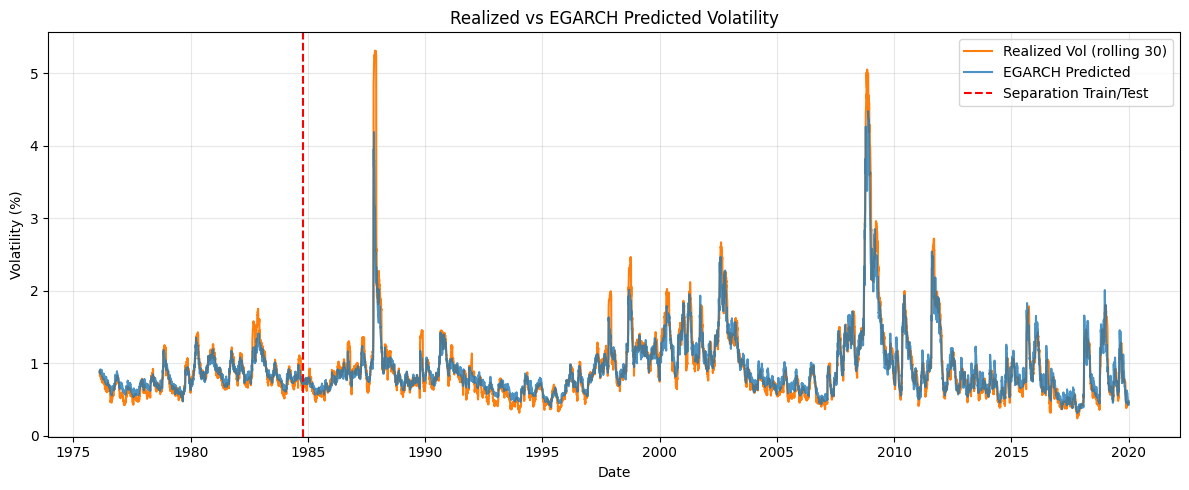

RMSE: 0.1880
MAE: 0.1066
QLIKE = 0.0409


In [481]:
df_egarch = pd.concat(
    [realized_vol.rename("realized"), 
     full_predictions.rename("predicted")],
    axis=1,
    join="inner"
)

df_egarch = df_egarch.dropna()

realized  = df_egarch["realized"]
predicted = df_egarch["predicted"]

plt.figure(figsize=(12,5))
plt.plot(realized.index, realized, label=f'Realized Vol (rolling {window})', color='tab:orange')
plt.plot(predicted.index, predicted, label='EGARCH Predicted', alpha=0.8, color='tab:blue')

# optional uncertainty band around prediction (±20%)
#plt.fill_between(predicted.index, predicted * 0.8, predicted * 1.2, color='tab:blue', alpha=0.06)
plt.title('Realized vs EGARCH Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.axvline(x=train_data.index[-1], linestyle='--', c='r', label='Separation Train/Test')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print simple accuracy metrics on the overlapping sample
pred_var = predicted ** 2
real_var = realized ** 2
rmse = np.sqrt(mean_squared_error(realized, predicted))
mae = mean_absolute_error(realized, predicted)
qLike = qlike(real_var, pred_var)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'QLIKE = {qLike:.4f}')